In [4]:
%matplotlib inline
import torch
from sebm.sgld import SGLD_sampler
from sebm.models import EBM
dataset =  'cifar10' # 'svhn' # 'cifar10' # 'mnist' #  'flowers102' #
if dataset == 'mnist' or dataset =='fashionmnist':
    input_channels, im_height, im_width = 1, 28, 28
else:
    input_channels, im_height, im_width = 3, 32, 32
device = torch.device('cuda:1')
arch =  'simplenet'
seed = 1
lr, reg_alpha = 5e-5, 5e-2
# lr, reg_alpha = 5e-5, 5e-3
# lr, reg_alpha = 1e-4, 1e-1
# lr, reg_alpha = 5e-5, 5e-3
optimize_priors = False
channels, kernels, strides, paddings =[64,128,256,512], [3,4,4,4], [1,2,2,2], [1,1,1,1]
# hidden_dim, latent_dim, activation = [1024], 128, 'LeakyReLU'
hidden_dim, latent_dim, activation = [1024,128], 1, 'Swish'
# 
# channels, kernels, strides, paddings =[64,64,32,32], [3,4,4,4], [1,2,2,2], [1,1,1,1]
# hidden_dim, latent_dim, activation = [128,128], 1, 'Swish'

data_noise_std = 3e-2
sgld_noise_std, sgld_lr, sgld_num_steps = 7.5e-3, 2.0, 60
buffer_init, buffer_dup_allowed = True, True
data_dir = '../../../sebm_data/'
load_version = 'igebm-d=%s-seed=%d-lr=%s-zd=%d-d_ns=%s-sgld-ns=%s-lr=%s-steps=%s-reg=%s-act=%s-arch=%s' % (dataset, seed, lr, latent_dim, data_noise_std, sgld_noise_std, sgld_lr, sgld_num_steps,  reg_alpha, activation, arch)

ebm = EBM(arch=arch,
                im_height=im_height, 
                im_width=im_width, 
                input_channels=input_channels, 
                channels=channels, 
                kernels=kernels, 
                strides=strides, 
                paddings=paddings, 
                hidden_dim=hidden_dim,
                latent_dim=latent_dim,
                activation=activation)
ebm = ebm.cuda().to(device)
print('Loading trained weights..')
ebm.load_state_dict(torch.load('../weights/cp-%s' % load_version)['model_state_dict'])

Loading trained weights..


<All keys matched successfully>

In [5]:
from sebm.eval import *
evaluator = Evaluator_EBM(ebm, device, dataset, data_dir, data_noise_std=1e-2)

In [ ]:
similarity_ebm_z_space(evaluator, 
                       train_batch_size=5000, 
                       test_batch_size=5000,
                       model_name='igebm')

In [ ]:
paired = torch.cat((ys_test.unsqueeze(-1), pred_ys_test), -1)
torch.save(paired, 'confusion_matrix_labels_igebm_z_%s.pt' % dataset)

In [ ]:
num_shots = 1
num_runs = 10
Accu = []
for i in range(num_runs):
    print('dataset=%s, run=%d / %d' % (dataset, i+1, num_runs))
    data = torch.load('/home/hao/Research/sebm_data/fewshots/%s/%d/%d.pt' % (dataset, num_shots*10, i+1))
    accu = train_logistic_classifier(evaluator, train_data=data)
    Accu.append(np.array([accu]))
Accu = np.concatenate(Accu)
print('mean=%.4f, std=%.4f' % (Accu.mean(), Accu.std()))

In [ ]:
# scores = evaluator.oodauc(dataset_ood='texture', score='gradient')
# scores

sample unconditionally from ebm..
plotting the samples..


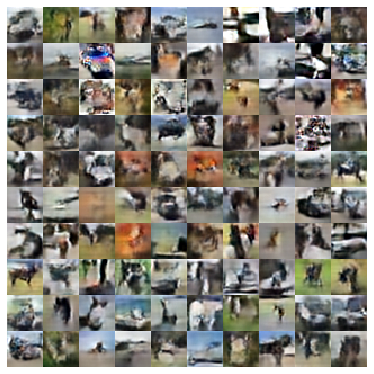

In [6]:
images_ebm = evaluator.uncond_sampling(batch_size=100, 
                                          sgld_steps=1000,
                                          sgld_lr=2.0,
                                          sgld_noise_std=1e-3,
                                          grad_clipping=False,
                                          init_samples=None,
                                          logging_interval=None)
evaluator.plot_final_samples(images_ebm, fs=5)